In [56]:
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import glob, os
import matplotlib.pyplot as plt

In [62]:
img_list = []
IMG_NAME = "test"
img_list.append(glob.glob(os.path.join('C:\\Users\\USER\\Downloads\\panorama_test\\',IMG_NAME,'*.jpg')))
img_list = sorted(img_list)
cnt = 0
for i in img_list:
    if not i:
        cnt +=1
img_list= img_list[cnt]
imgs = []
print(img_list)
for img_path in img_list:
    img = cv2.imread(img_path)
    imgs.append(img)

['C:\\Users\\USER\\Downloads\\panorama_test\\test\\KakaoTalk_20210504_131202663.jpg', 'C:\\Users\\USER\\Downloads\\panorama_test\\test\\KakaoTalk_20210504_131202663_02.jpg', 'C:\\Users\\USER\\Downloads\\panorama_test\\test\\KakaoTalk_20210504_131202663_04.jpg', 'C:\\Users\\USER\\Downloads\\panorama_test\\test\\KakaoTalk_20210504_131202663_05.jpg', 'C:\\Users\\USER\\Downloads\\panorama_test\\test\\KakaoTalk_20210504_131202663_06.jpg', 'C:\\Users\\USER\\Downloads\\panorama_test\\test\\KakaoTalk_20210504_131202663_07.jpg']


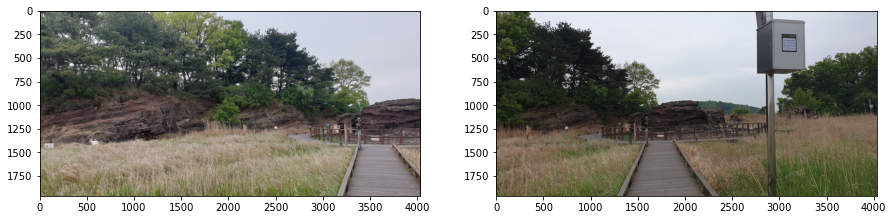

In [81]:
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.imshow(cv2.cvtColor(imgs[1],cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.imshow(cv2.cvtColor(imgs[2],cv2.COLOR_BGR2RGB))

# 1. SIFT 알고리즘으로 Feature 추출 & 매칭

In [58]:
sift = cv2.xfeatures2d.SIFT_create()
kp  = []
des = []
for i in imgs:
    kp1,des1 = sift.detectAndCompute(i,None)
    kp.append(kp1)
    des.append(des1)

In [133]:
print(des[0])

[[  6.   8.   2. ...   8.   3.   7.]
 [  0.   0.   0. ...  12.  10.  15.]
 [  1.   1.   2. ... 121.  25.   2.]
 ...
 [ 11.  10.  47. ...   1.   0.  22.]
 [  7.  43.  13. ...   3.   3.   1.]
 [ 16.  29.  92. ...   0.   0.   0.]]


In [134]:
print(kp[0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [60]:
ratio = 0.85
min_match = 10

raw_matches = cv2.BFMatcher().knnMatch(des[1], des[2], k=2)
good_points = []
good_matches = []
for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])
matches = cv2.drawMatchesKnn(imgs[1], kp[1], imgs[2], kp[2], good_matches, None, flags=2)

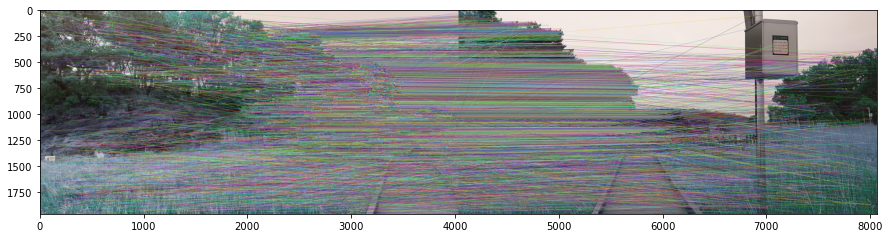

In [61]:
plt.figure(figsize=(15,10))
plt.imshow(matches)
#print(matches)

In [130]:
print(good_matches)

[[<DMatch 000001D20FCBF750>], [<DMatch 000001D20FCBD110>], [<DMatch 000001D20FCC2F50>], [<DMatch 000001D20FCC57D0>], [<DMatch 000001D20FCC8A10>], [<DMatch 000001D20FCC8A50>], [<DMatch 000001D20FCC8C90>], [<DMatch 000001D20FCCA990>], [<DMatch 000001D20FCCE490>], [<DMatch 000001D20FCCE4D0>], [<DMatch 000001D20FCD1BD0>], [<DMatch 000001D20FCD1DD0>], [<DMatch 000001D20FCD1E50>], [<DMatch 000001D20FCD35D0>], [<DMatch 000001D20FCD74D0>], [<DMatch 000001D20FCD7C90>], [<DMatch 000001D20FCDA3D0>], [<DMatch 000001D20FCDC210>], [<DMatch 000001D20FCDCA50>], [<DMatch 000001D20FCE0D50>], [<DMatch 000001D20FCE3150>], [<DMatch 000001D20FCE3590>], [<DMatch 000001D20FCE5910>], [<DMatch 000001D20FCE5D50>], [<DMatch 000001D20FCE7610>], [<DMatch 000001D20FF80350>], [<DMatch 000001D20FF80390>], [<DMatch 000001D20FF85950>], [<DMatch 000001D20FF87450>], [<DMatch 000001D20FF87F10>], [<DMatch 000001D20FF89050>], [<DMatch 000001D20FF89790>], [<DMatch 000001D20FF8B650>], [<DMatch 000001D20FF8E7D0>], [<DMatch 0000

# 2. RANSAC으로 Homograpy 찾기

In [83]:
if len(good_points) > min_match:
    image1_kp = np.float32( [kp[1][i].pt for (_, i) in good_points])
    image2_kp = np.float32([kp[2][i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)

In [84]:
print(H)

[[ 4.43926035e-01  5.97988755e-03  1.89219489e+03]
 [-1.51236327e-01  8.44031902e-01  1.74852318e+02]
 [-1.36729400e-04 -2.43073511e-06  1.00000000e+00]]


# 3. Homograpy Matrix로 warping 변환 

In [88]:
def create_mask(img1,img2,version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

smoothing_window_size = 800
# H = registration(img1,img2)

image1 = imgs[1]
image2 = imgs[2]

height_img1 = image1.shape[0]
width_img1 = image1.shape[1]
width_img2 = image2.shape[1]
height_panorama = height_img1
width_panorama = width_img1 + width_img2

panorama1 = np.zeros((height_panorama, width_panorama, 3))
mask1 = create_mask(image1, image2, version='left_image')
panorama1[0:image1.shape[0], 0:image1.shape[1], :] = image1
panorama1 *= mask1
mask2 = create_mask(image1,image2,version='right_image')
panorama2 = cv2.warpPerspective(image2, H, (width_panorama, height_panorama))*mask2
result = panorama1 + panorama2

rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]

cv2.warpPerspective를 이용

In [127]:
test = cv2.warpPerspective(image2, H, (width_panorama, height_panorama))

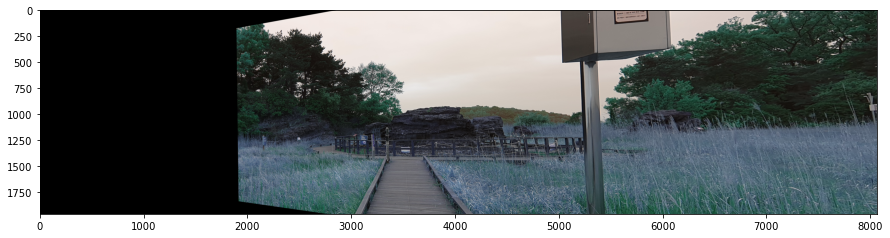

In [128]:
plt.figure(figsize=(15,10))
plt.imshow(test/255.0)

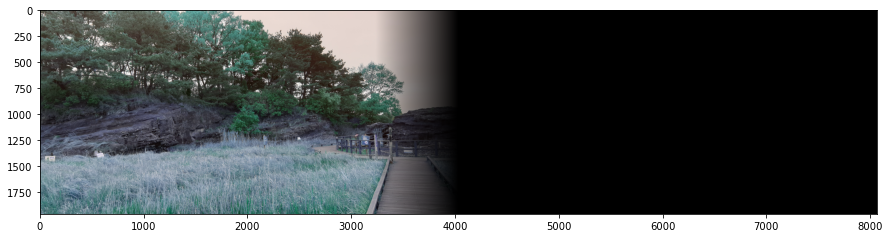

In [92]:
plt.figure(figsize=(15,10))
plt.imshow(panorama1/255.0)

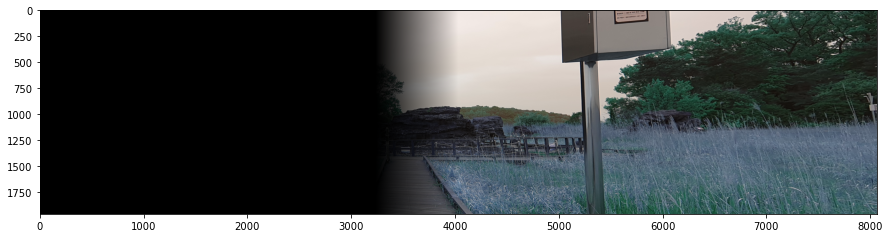

In [93]:
plt.figure(figsize=(15,10))
plt.imshow(panorama2/255.0)

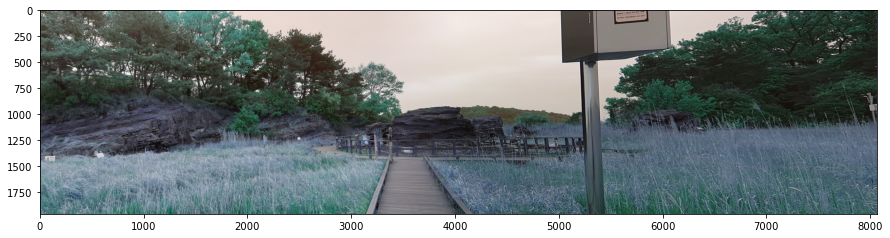

In [125]:
plt.figure(figsize=(15,10))
plt.imshow(final_result/255.0)

IndexError: index 8064 is out of bounds for axis 1 with size 8064

# cv2.createStitcher() 적용 

In [96]:
stitcher = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
(status, stitched) = stitcher.stitch([imgs[1],imgs[2]])

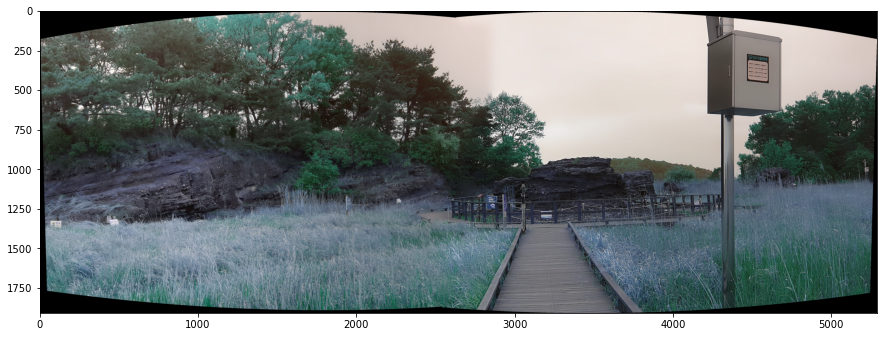

In [97]:

plt.figure(figsize=(15,10))
plt.imshow(stitched)

In [98]:
gray = cv2.cvtColor(stitched,cv2.COLOR_BGR2GRAY)
thresh = cv2.bitwise_not(cv2.threshold(gray,0,255,cv2.THRESH_BINARY)[1])
thresh = cv2.medianBlur(thresh,5)
stitched_copy = stitched.copy()
thresh_copy = thresh.copy()

while np.sum(thresh_copy) > 0:
    thresh_copy = thresh_copy[1:-1,1:-1]
    stitched_copy = stitched_copy[1:-1,1:-1]

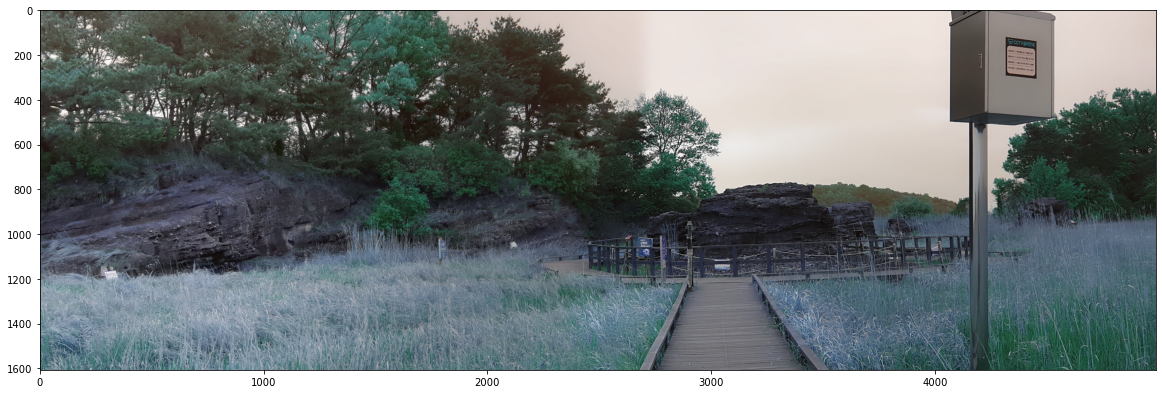

In [126]:
plt.figure(figsize=(20,20))
plt.imshow(stitched_copy)
#plt.imshow(cv2.cvtColor(stitched_copy,cv2.COLOR_BGR2RGB))